In [1]:
import pandas as pd
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import pickle

# full numbers
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
# standardize plots
def custom_plots(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.grid(False)
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    #size of labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #size of title
    plt.title(ax.get_title(), fontsize=16)
    #size of legend

In [4]:
src = "../../data/"
with open(join(src, "dtypes_config.pickle"), "rb") as file:
    DTYPES = pickle.load(file)

In [6]:
df = pd.read_csv(join(src, 
                      "discussions_replies.csv.gz"), # excluding zero-replies
                         compression="gzip",
                         usecols=[
                             # tweet information
                              "id", 
                              "created_at",
                              "type",
                              "status",
                              "conversation_id", 
                              "domain",
                              "Rating", 
                              "Orientation",

                              # author information
                              "author_id",
                              "author.followers_count",
                              "author.following_count",
                              "author.tweet_count",

                              # sentiment
                              "anger", "fear", "disgust", "sadness",
                              "joy", "pride", "hope"],
                          dtype=DTYPES)

len(df)

11751469

In [7]:
df["type"].value_counts()

type
reply      10831242
starter      920227
Name: count, dtype: int64

In [8]:
df["status"].value_counts()

status
complete    11751469
Name: count, dtype: int64

## Transform data

### Orientation

In [9]:
def recode_orientation(x):
    if pd.isna(x):
        return None
    elif "Neutral" in x:
        return 0
    elif "Right" in x:
        return 1
    elif "Left" in x:
        return -1
    else:
        return None
    
df["Bias"] = \
    df["Orientation"].apply(recode_orientation)

### Rating

In [10]:
def recode_rating(x):
    if pd.isna(x):
        return None
    elif "T" in x:
        return 0
    elif "N" in x:
        return 1
    else:
        return None
    
df["Rating"] = \
    df["Rating"]\
        .apply(recode_rating)

## Aggregate data per starter vs reply

## Starters

In [11]:
df_starters = df[
    df["type"] == "starter"]
len(df_starters)

920227

In [12]:
# how many missing values in Rating?
df_starters["Rating"].isna().sum()

3408

In [13]:
# drop missing values
df_starters = df_starters.dropna(subset=["Rating"])
len(df_starters)

916819

In [14]:
# how many duplicated tweets?
df_starters["conversation_id"].duplicated().sum()

2873

In [15]:
# drop duplicates
df_starters = df_starters.drop_duplicates(subset=["conversation_id"])
len(df_starters)

913946

In [16]:
#calculate word count per initial tweet
df_starters["word_count"] = \
    df_starters["text"]\
        .apply(lambda x: len(x.split(" ")))

df_starters["word_count"].describe()

KeyError: 'text'

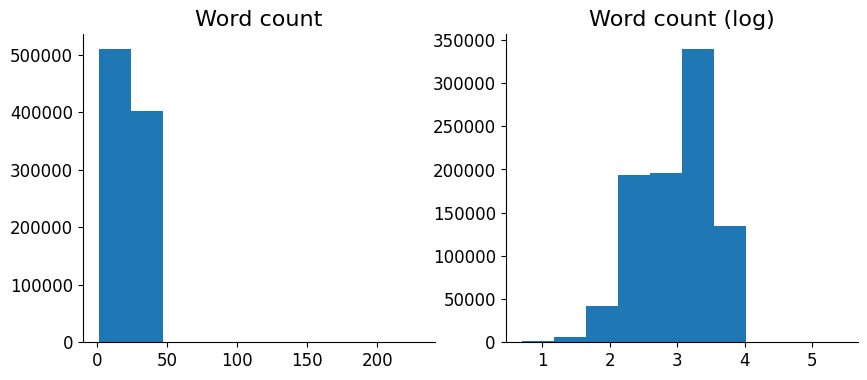

In [ ]:
#log-transform word count
df_starters["word_count_log"] = \
        np.log1p(df_starters["word_count"])

# visualize both distributions in subplots next to each other
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
df_starters["word_count"]\
    .hist()
plt.title("Word count")
custom_plots()

plt.subplot(1, 2, 2)
df_starters["word_count_log"]\
    .hist()
plt.title("Word count (log)")
custom_plots()

### Tweet count

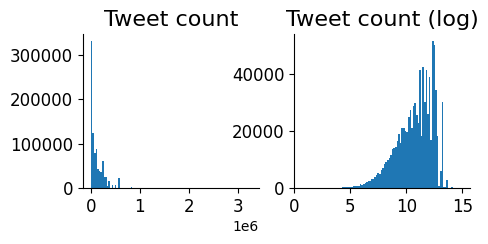

In [ ]:
#distributions of follower count and log follower count
df_starters["author.tweet_count_log"] = \
    np.log1p(df_starters["author.tweet_count"])

plt.figure(figsize=(5, 2))
plt.subplot(1, 2, 1)
df_starters["author.tweet_count"]\
    .hist(bins=100)
plt.title("Tweet count")
custom_plots()

plt.subplot(1, 2, 2)
df_starters["author.tweet_count_log"]\
    .hist(bins=100)
plt.title("Tweet count (log)")
custom_plots()

### Follower count

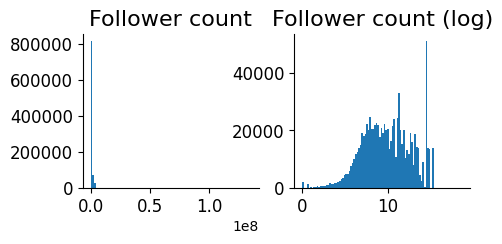

In [ ]:
#distributions of follower count and log follower count
df_starters["author.followers_count_log"] = \
    np.log1p(df_starters["author.followers_count"])

plt.figure(figsize=(5,2))
plt.subplot(1, 2, 1)
df_starters["author.followers_count"]\
    .hist(bins=100)
plt.title("Follower count")
custom_plots()

plt.subplot(1, 2, 2)
df_starters["author.followers_count_log"]\
    .hist(bins=100)
plt.title("Follower count (log)", fontsize=6)
custom_plots()

### Following count

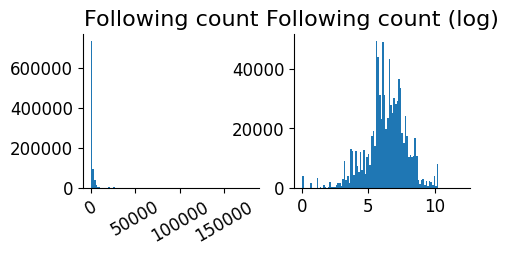

In [ ]:
df_starters["author.following_count_log"] = \
    np.log1p(df_starters["author.following_count"])

plt.figure(figsize=(5, 2))
plt.subplot(1, 2, 1)
df_starters["author.following_count"]\
    .hist(bins=100)
plt.xticks(rotation=30)
plt.title("Following count")
custom_plots()

plt.subplot(1, 2, 2)
df_starters["author.following_count_log"]\
    .hist(bins=100)
plt.title("Following count (log)")
custom_plots()

### Emotions

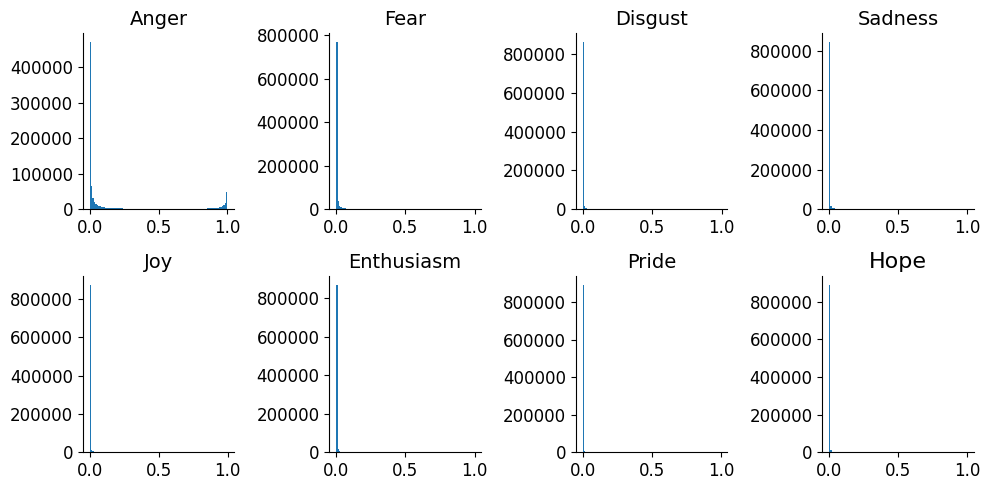

In [ ]:
emotions = ["anger", "fear", "disgust", "sadness",
            "joy", "pride", "hope"]

fig, axes = plt.subplots(2, 4, figsize=(10, 5))

axes = axes.flatten()
for i, emotion in enumerate(emotions):
    ax = axes[i]  
    df_starters[emotion].hist(bins=100, ax=ax) 
    ax.set_title(f'{emotion.capitalize()}', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    custom_plots(ax=ax)


plt.tight_layout()
plt.show()

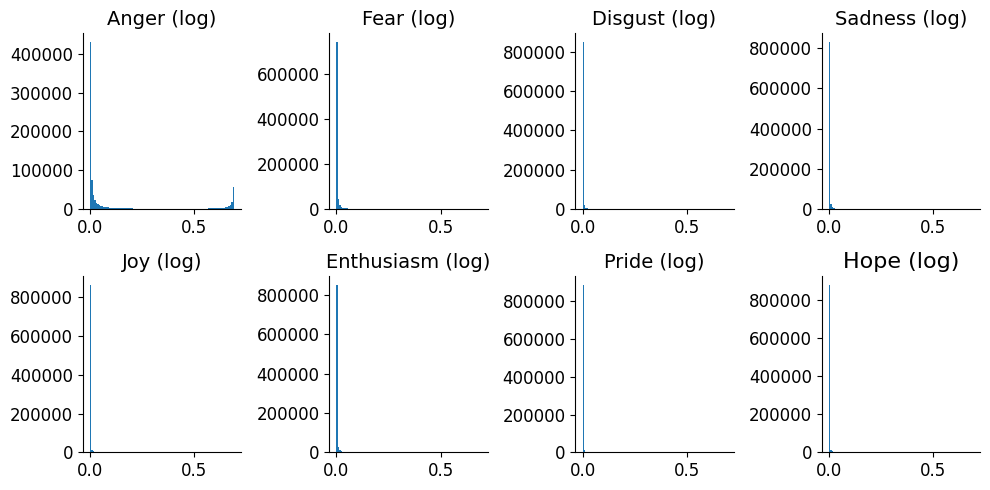

In [ ]:
# log-transform the emotion scores
for emotion in emotions:
     df_starters[f"{emotion}_log"] = \
          np.log1p(df_starters[emotion])
     
# visualize the log-transformed emotion scores
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

axes = axes.flatten()

for i, emotion in enumerate(emotions):
    ax = axes[i]
    df_starters[f"{emotion}_log"].hist(bins=100, ax=ax)
    ax.set_title(f'{emotion.capitalize()} (log)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    custom_plots(ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
starters_avg = \
    df_starters\
        .drop(columns=["status",
                        "type",
                        ])

starters_avg.columns

Index(['conversation_id', 'domain', 'author_id', 'created_at',
       'author.followers_count', 'author.following_count',
       'author.tweet_count', 'Rating', 'Score', 'anger', 'fear', 'disgust',
       'sadness', 'joy', 'pride', 'hope', 'Orientation', 'word_count',
       'word_count_log', 'author.tweet_count_log',
       'author.followers_count_log', 'author.following_count_log', 'anger_log',
       'fear_log', 'disgust_log', 'sadness_log', 'joy_log', 'pride_log',
       'hope_log'],
      dtype='object')

## Replies

In [ ]:
df_replies = df[
    df["type"] == "reply"]
len(df_replies)

10831242

In [ ]:
# are there conversations with less than one reply?
df_replies["conversation_id"].value_counts().min()

1

In [ ]:
# calculate time between first and last tweet in a conversation
pd.options.mode.chained_assignment = None

df_replies["created_at"] = \
    pd.to_datetime(df_replies["created_at"])

df_time = \
    df_replies.groupby("conversation_id")["created_at"]\
                    .apply(lambda x: x.max() - x.min())\
                    .reset_index(name="time_diff")

df_time["time_diff"] = \
    df_time["time_diff"].dt.total_seconds()

In [ ]:
df_time["time_diff"].describe()

count     852326.000
mean      241243.183
std      2315363.389
min            0.000
25%            0.000
50%         2409.000
75%        45888.000
max     78625706.000
Name: time_diff, dtype: float64

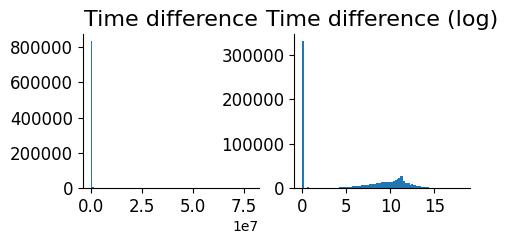

In [ ]:
df_time["time_diff_log"] = np.log1p(df_time["time_diff"])

plt.figure(figsize=(5, 2))
plt.subplot(1, 2, 1)
df_time["time_diff"]\
    .hist(bins=100)
plt.title("Time difference")
custom_plots()

plt.subplot(1, 2, 2)
df_time["time_diff_log"]\
    .hist(bins=100)
plt.title("Time difference (log)")
custom_plots()

In [ ]:
len(df_time) == df_replies["conversation_id"].nunique()

True

### Aggregate emotions in replies

In [ ]:
df_replies.columns

Index(['conversation_id', 'id', 'domain', 'author_id', 'created_at', 'text',
       'author.followers_count', 'author.following_count',
       'author.tweet_count', 'Rating', 'Score', 'anger', 'fear', 'disgust',
       'sadness', 'joy', 'enthusiasm', 'pride', 'hope', 'type', 'status',
       'Orientation'],
      dtype='object')

In [ ]:
#for every emotion, calculate the avg per conversation replies
avg_variables = [
    "anger", "fear", "disgust", "sadness", 
    "joy", "pride", "hope", 
    "author.tweet_count"]

replies_avg = \
    df_replies\
        .groupby("conversation_id")[avg_variables]\
        .mean()\
        .reset_index()

for col in replies_avg.columns:
    if col != "conversation_id":
        replies_avg.rename(columns={col: col + "_avg"}, 
                              inplace=True)

len(replies_avg)

852326

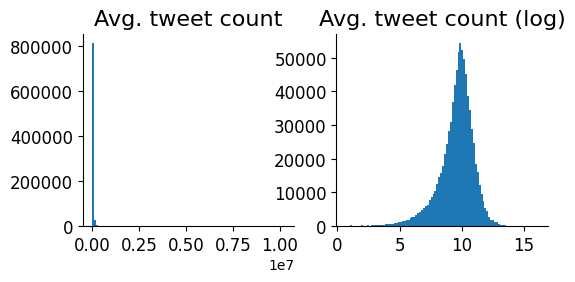

In [ ]:
#log-transform tweet count
replies_avg["author.tweet_count_avg_log"] = \
    np.log1p(replies_avg["author.tweet_count_avg"])

#plot both distributions next to each other
plt.figure(figsize=(6, 2.5))

plt.subplot(1, 2, 1)
replies_avg["author.tweet_count_avg"]\
    .hist(bins=100)
plt.title("Avg. tweet count")
custom_plots()

plt.subplot(1, 2, 2)
replies_avg["author.tweet_count_avg_log"]\
    .hist(bins=100)
plt.title("Avg. tweet count (log)")
custom_plots()

In [ ]:
# merge reply aggregates
df_replies_avg = \
    replies_avg.merge(df_time, on="conversation_id")
len(replies_avg)

852326

In [ ]:
df_replies_avg

,conversation_id,anger_avg,fear_avg,disgust_avg,sadness_avg,joy_avg,enthusiasm_avg,pride_avg,hope_avg,author.tweet_count_avg,author.tweet_count_avg_log,time_diff,time_diff_log
0,1311458383812276224,0.991,0.003,0.002,0.001,0.001,0.008,0.001,0.003,18275.000,9.813,0.000,0.000
1,1311462162708279297,0.003,0.001,0.001,0.000,0.001,0.001,0.001,0.001,369913.000,12.821,0.000,0.000
2,1311462180391395329,0.451,0.006,0.002,0.010,0.009,0.001,0.002,0.001,11253.667,9.329,16075.000,9.685
3,1311462201052540929,0.386,0.004,0.005,0.003,0.003,0.004,0.002,0.004,25501.229,10.147,244936.000,12.409
4,1311463707688546305,0.459,0.006,0.034,0.052,0.003,0.002,0.001,0.002,20090.194,9.908,61890.000,11.033
...,...,...,...,...,...,...,...,...,...,...,...,...,...
852321,1509309133211815936,0.452,0.004,0.008,0.003,0.072,0.002,0.003,0.002,6001.286,8.700,409470.000,12.923
852322,1509310013759803392,0.410,0.001,0.001,0.001,0.000,0.001,0.000,0.001,3261.000,8.090,0.000,0.000
852323,1509310516736368643,0.346,0.002,0.002,0.009,0.002,0.001,0.001,0.001,4313.100,8.370,82646.000,11.322
852324,1509313664221810688,0.003,0.003,0.005,0.003,0.002,0.001,0.000,0.000,1114.000,7.017,0.000,0.000


## Merge starter and reply aggregates 

In [ ]:
discussion_replies = \
    starters_avg\
       .merge(df_replies_avg, 
              on=["conversation_id"], 
              how="inner")

# discussion_replies.head(3)

In [ ]:
discussion_replies.columns

Index(['conversation_id', 'domain', 'author_id', 'created_at',
       'author.followers_count', 'author.following_count',
       'author.tweet_count', 'Rating', 'Score', 'anger', 'fear', 'disgust',
       'sadness', 'joy', 'pride', 'hope', 'Orientation', 'word_count',
       'word_count_log', 'author.tweet_count_log',
       'author.followers_count_log', 'author.following_count_log', 'anger_log',
       'fear_log', 'disgust_log', 'sadness_log', 'joy_log', 'pride_log',
       'hope_log', 'anger_avg', 'fear_avg', 'disgust_avg', 'sadness_avg',
       'joy_avg', 'enthusiasm_avg', 'pride_avg', 'hope_avg',
       'author.tweet_count_avg', 'author.tweet_count_avg_log', 'time_diff',
       'time_diff_log'],
      dtype='object')

In [ ]:
# drop some variables
discussion_replies = \
    discussion_replies.drop(columns=[
        "enthusiasm_avg"
    ])

In [ ]:
len(discussion_replies)

852206

In [ ]:
discussion_replies["Rating"].value_counts()

0.000    813547
1.000     38659
Name: Rating, dtype: int64

In [ ]:
print(f'Number of conversations: {len(discussion_replies)}')

Number of conversations: 852206


In [ ]:
num_tweets = len(df[df["conversation_id"].isin(discussion_replies["conversation_id"])])
print(f'Number of tweets: {num_tweets}')

Number of tweets: 11688608


In [ ]:
# are there missing values in any of the variables?
discussion_replies.isna().sum()

conversation_id               0
domain                        0
author_id                     0
created_at                    0
author.followers_count        0
author.following_count        0
author.tweet_count            0
Rating                        0
Score                         0
anger                         0
fear                          0
disgust                       0
sadness                       0
joy                           0
pride                         0
hope                          0
Orientation                   0
word_count                    0
word_count_log                0
author.tweet_count_log        0
author.followers_count_log    0
author.following_count_log    0
anger_log                     0
fear_log                      0
disgust_log                   0
sadness_log                   0
joy_log                       0
pride_log                     0
hope_log                      0
anger_avg                     0
fear_avg                      0
disgust_

In [ ]:
discussion_replies.to_csv(join(src,
                            "discussions_replies_aggregates.csv"),
                            index=False)

## Aggregate first responders data

In [ ]:
df_first_replies = df_replies\
        .sort_values("created_at")

df_first_replies = \
    df_first_replies\
        .groupby("conversation_id")\
        .first()\
        .reset_index()

df_first_replies.conversation_id.nunique() == len(df_first_replies)

True

In [ ]:
len(df_first_replies)

852326

In [ ]:
df_first_replies.columns

Index(['conversation_id', 'id', 'domain', 'author_id', 'created_at', 'text',
       'author.followers_count', 'author.following_count',
       'author.tweet_count', 'Rating', 'Score', 'anger', 'fear', 'disgust',
       'sadness', 'joy', 'enthusiasm', 'pride', 'hope', 'type', 'status',
       'Orientation'],
      dtype='object')

In [ ]:
#drop columns that are not needed
df_first_replies = df_first_replies.drop(columns=["created_at", 
                                                  "type",
                                                  "status",
                                                  "Rating",
                                                  "Orientation",
                                                  "author.followers_count",
                                                  "author.following_count"])

df_first_replies.columns

Index(['conversation_id', 'id', 'author_id', 'author.tweet_count', 'anger',
       'fear', 'disgust', 'sadness', 'joy', 'enthusiasm', 'pride', 'hope'],
      dtype='object')

In [ ]:
#keep only conversation_id and emotion columns
df_first_replies_avg = \
    df_first_replies[["conversation_id", "id", "author_id"] + 
                      avg_variables].copy()

#add suffix to emotion columns
for col in df_first_replies_avg.columns:
    if col not in ["conversation_id", "id", "author_id"]:
        df_first_replies_avg\
            .rename(columns={col: col + "_first"}, 
                    inplace=True)
        
df_first_replies_avg.head(3)

,conversation_id,id,author_id,anger_first,fear_first,disgust_first,sadness_first,joy_first,enthusiasm_first,pride_first,hope_first,author.tweet_count_first
0,1311458383812276224,1311463696368103428,1285712959709339649,0.991,0.003,0.002,0.001,0.001,0.008,0.001,0.003,18275.000
1,1311462162708279297,1311462185634275330,1267192643831947265,0.003,0.001,0.001,0.000,0.001,0.001,0.001,0.001,369913.000
2,1311462180391395329,1311467250151424001,1238090439267217411,0.997,0.012,0.005,0.005,0.001,0.001,0.001,0.002,9077.000


In [ ]:
len(df_first_replies_avg)

852326

In [ ]:
df_first_replies_avg["author.tweet_count_first"].describe()

count     852326.000
mean       30834.088
std        58516.660
min            1.000
25%         4290.250
50%        13689.000
75%        35441.000
max     10249392.000
Name: author.tweet_count_first, dtype: float64

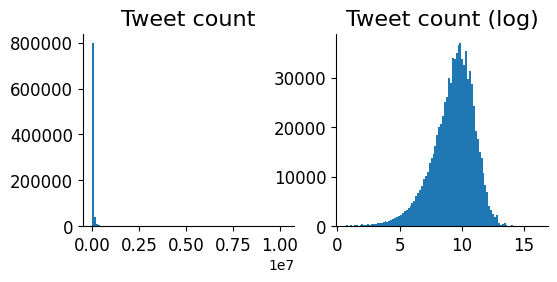

In [ ]:
#logtransform tweet count
df_first_replies_avg["author.tweet_count_first_log"] = \
    np.log1p(df_first_replies_avg["author.tweet_count_first"])

plt.figure(figsize=(6, 2.5))
plt.subplot(1, 2, 1)
df_first_replies_avg["author.tweet_count_first"]\
    .hist(bins=100)
plt.title("Tweet count")
custom_plots()

plt.subplot(1, 2, 2)
df_first_replies_avg["author.tweet_count_first_log"]\
    .hist(bins=100)
plt.title("Tweet count (log)")
custom_plots()

In [ ]:
# rename author_id to first_author_id
df_first_replies_avg.rename(columns={"author_id": "first_author_id"}, 
                            inplace=True)
first_replies_avg = \
    starters_avg\
       .merge(df_first_replies_avg, 
              on="conversation_id", 
              how="inner")
len(first_replies_avg)

852206

In [ ]:
first_replies_avg.columns

Index(['conversation_id', 'domain', 'author_id', 'created_at',
       'author.followers_count', 'author.following_count',
       'author.tweet_count', 'Rating', 'Score', 'anger', 'fear', 'disgust',
       'sadness', 'joy', 'pride', 'hope', 'Orientation', 'word_count',
       'word_count_log', 'author.tweet_count_log',
       'author.followers_count_log', 'author.following_count_log', 'anger_log',
       'fear_log', 'disgust_log', 'sadness_log', 'joy_log', 'pride_log',
       'hope_log', 'id', 'first_author_id', 'anger_first', 'fear_first',
       'disgust_first', 'sadness_first', 'joy_first', 'enthusiasm_first',
       'pride_first', 'hope_first', 'author.tweet_count_first',
       'author.tweet_count_first_log'],
      dtype='object')

In [ ]:
# drop columns
first_replies_avg = \
    first_replies_avg\
        .drop(columns=[
            "enthusiasm_first"])

In [ ]:
# any duplicated conversations?
first_replies_avg["conversation_id"].duplicated().sum()

0

In [ ]:
# any missing values in Rating?
first_replies_avg["Rating"].isna().sum()

0

In [ ]:
# distribution of Rating
first_replies_avg["Rating"].value_counts()

0.000    813547
1.000     38659
Name: Rating, dtype: int64

In [ ]:
# how many conversations left?
len(first_replies_avg)

852206

In [ ]:
first_replies_avg.to_csv(join(src,
                              "first_replies_aggregates.csv"),
                                        index=False)

## Aggregate same responders data

In [ ]:
# identify authors who have replied to N and T
rating_authors = \
    df_replies\
        .groupby(["author_id", "Rating"])\
        .size()\
        .reset_index(name="count")\
        .pivot(index="author_id", 
               columns="Rating", 
               values="count")\
        .reset_index()

rating_authors.head(2)

Rating,author_id,0.0,1.0
0,4560,1.000,NaN
1,5267,4.000,NaN


In [ ]:
# drop rows with missing values
same_authors = \
    rating_authors.dropna()

same_authors.head(2)

Rating,author_id,0.0,1.0
11,620153,10.000,4.000
28,1001761,17.000,1.000


In [ ]:
# extract list of author IDs
same_authors_list = same_authors["author_id"].tolist()
len(same_authors_list)

7714

In [ ]:
#keep only the tweets from authors list
df_same_authors = \
    df_replies[df_replies["author_id"].isin(same_authors_list)]
df_same_authors["author_id"].nunique()

7714

In [ ]:
df_same_authors["Rating"].value_counts()

0.000    143633
1.000     57721
Name: Rating, dtype: int64

In [ ]:
len(df_same_authors)

2586712

In [ ]:
# sample one tweet per author per rating
df_same_authors_one = \
    df_same_authors\
        .groupby(["author_id", "Rating"])\
        .sample(1)

len(df_same_authors_one)

15428

In [ ]:
df_same_authors_one.columns

Index(['conversation_id', 'id', 'domain', 'author_id', 'created_at', 'text',
       'author.followers_count', 'author.following_count',
       'author.tweet_count', 'Rating', 'Score', 'anger', 'fear', 'disgust',
       'sadness', 'joy', 'enthusiasm', 'pride', 'hope', 'type', 'status',
       'Orientation'],
      dtype='object')

In [ ]:
# rename author_id to same_author_id
df_same_authors_one.rename(columns={"author_id": "same_author_id",
                                    "author.tweet_count": "same_author.tweet_count",
                                    "id": "same_id"}, 
                           inplace=True)

for emotion in emotions:
    df_same_authors_one.rename(columns={emotion: f"{emotion}_same"}, 
                               inplace=True)

df_same_authors_one.columns

Index(['conversation_id', 'same_id', 'domain', 'same_author_id', 'created_at',
       'text', 'author.followers_count', 'author.following_count',
       'same_author.tweet_count', 'Rating', 'Score', 'anger_same', 'fear_same',
       'disgust_same', 'sadness_same', 'joy_same', 'enthusiasm_same',
       'pride_same', 'hope_same', 'type', 'status', 'Orientation'],
      dtype='object')

In [ ]:
df_same_authors_one = \
    df_same_authors_one\
        .drop(columns=["type",
                       "status",
                       "created_at",
                       "Orientation",
                       "Rating",
                       "author.followers_count",
                       "author.following_count"])

In [ ]:
starters_avg.columns

Index(['conversation_id', 'domain', 'author_id', 'created_at',
       'author.followers_count', 'author.following_count',
       'author.tweet_count', 'Rating', 'Score', 'anger', 'fear', 'disgust',
       'sadness', 'joy', 'pride', 'hope', 'Orientation', 'word_count',
       'word_count_log', 'author.tweet_count_log',
       'author.followers_count_log', 'author.following_count_log', 'anger_log',
       'fear_log', 'disgust_log', 'sadness_log', 'joy_log', 'pride_log',
       'hope_log'],
      dtype='object')

In [ ]:
# merge back with starters
same_responders_avg = \
    df_same_authors_one\
        .merge(starters_avg, 
               on="conversation_id",
               how="left")

same_responders_avg.head(2)

,conversation_id,same_id,same_author_id,same_author.tweet_count,anger_same,fear_same,disgust_same,sadness_same,joy_same,pride_same,...,author.tweet_count_log,author.followers_count_log,author.following_count_log,anger_log,fear_log,disgust_log,sadness_log,joy_log,pride_log,hope_log
0,1401772458797981698,1401829927117332490,620153,7929.000,0.001,0.001,0.001,0.001,0.003,0.056,...,11.258,9.085,7.766,0.076,0.001,0.001,0.001,0.001,0.000,0.000
1,1365675840739098625,1365721343166152704,620153,7929.000,0.001,0.001,0.001,0.007,0.003,0.000,...,8.894,9.420,8.443,0.002,0.001,0.001,0.001,0.001,0.000,0.001


In [ ]:
same_responders_avg.columns

Index(['conversation_id', 'same_id', 'same_author_id',
       'same_author.tweet_count', 'anger_same', 'fear_same', 'disgust_same',
       'sadness_same', 'joy_same', 'pride_same', 'hope_same', 'domain',
       'author_id', 'created_at', 'author.followers_count',
       'author.following_count', 'author.tweet_count', 'Rating', 'Score',
       'anger', 'fear', 'disgust', 'sadness', 'joy', 'pride', 'hope',
       'Orientation', 'word_count', 'word_count_log', 'author.tweet_count_log',
       'author.followers_count_log', 'author.following_count_log', 'anger_log',
       'fear_log', 'disgust_log', 'sadness_log', 'joy_log', 'pride_log',
       'hope_log'],
      dtype='object')

In [ ]:
same_responders_avg["author_id"].value_counts().value_counts()

1       962
2       284
3       121
4        43
5        31
       ... 
36        1
38        1
2283      1
42        1
2636      1
Name: author_id, Length: 69, dtype: int64

In [ ]:
same_responders_avg["author_id"].nunique()

1668

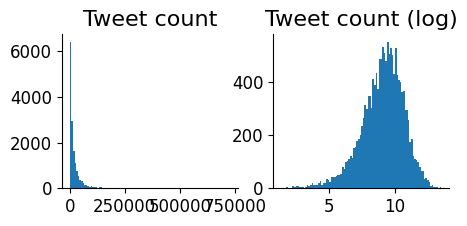

In [ ]:
# log-transform tweet count
same_responders_avg["same_author.tweet_count_log"] = \
    np.log1p(same_responders_avg["same_author.tweet_count"])

plt.figure(figsize=(5, 2))
plt.subplot(1, 2, 1)
same_responders_avg["same_author.tweet_count"]\
    .hist(bins=100)
plt.title("Tweet count")
custom_plots()

plt.subplot(1, 2, 2)
same_responders_avg["same_author.tweet_count_log"]\
    .hist(bins=100)
plt.title("Tweet count (log)")
custom_plots()

In [ ]:
same_responders_avg.columns

Index(['conversation_id', 'same_id', 'same_author_id',
       'same_author.tweet_count', 'anger_same', 'fear_same', 'disgust_same',
       'sadness_same', 'joy_same', 'pride_same', 'hope_same', 'domain',
       'author_id', 'created_at', 'author.followers_count',
       'author.following_count', 'author.tweet_count', 'Rating', 'Score',
       'anger', 'fear', 'disgust', 'sadness', 'joy', 'pride', 'hope',
       'Orientation', 'word_count', 'word_count_log', 'author.tweet_count_log',
       'author.followers_count_log', 'author.following_count_log', 'anger_log',
       'fear_log', 'disgust_log', 'sadness_log', 'joy_log', 'pride_log',
       'hope_log', 'same_author.tweet_count_log'],
      dtype='object')

In [ ]:
same_responders_avg["conversation_id"].nunique()

9809

In [ ]:
same_responders_avg["same_author_id"].nunique()

7714

In [ ]:
same_responders_avg["Rating"].value_counts()

0.000    9181
1.000    6244
Name: Rating, dtype: int64

In [ ]:
same_responders_avg.to_csv(join(src, 
                            "same_author_replies.csv"),
                            index=False)